In [167]:
import gym
import time
import torch as T
from supersuit import frame_stack_v1, color_reduction_v0, frame_skip_v0, max_observation_v0
import torchvision.models as models
from torchvision import transforms
from einops import rearrange
import matplotlib.pyplot as plt

In [150]:
def crop_bottom(x):
    return x[:,:,:172,:]

In [151]:
def preprocess(img):
    img = T.from_numpy(img).unsqueeze(0).float()
    img = rearrange(img, 'b h w c -> b c h w')
    img = crop_bottom(img)
    
    return img

In [152]:
def plot_state(state):
    fig = plt.figure(figsize=(12,6))
    fig.add_subplot(1, 2, 1)
    plt.imshow(state[0][0], cmap='gray');
    fig.add_subplot(1, 2, 2)
    plt.imshow(state[0][1], cmap='gray');
    plt.show()

In [153]:
FRAMES_TO_STACK = 2
FRAMES_TO_SKIP = 5

In [176]:
env = gym.make('MsPacman-v4')
env = color_reduction_v0(env, 'full')
env = max_observation_v0(env, 4)
env = frame_stack_v1(frame_skip_v0(env, FRAMES_TO_SKIP), FRAMES_TO_STACK)

#env = gym.make('MsPacmanNoFrameskip-v4') #v4 means action_repeat prob = 0
#env = gym.wrappers.atari_preprocessing.AtariPreprocessing(env, frame_skip=FRAMES_TO_SKIP, screen_size=200, noop_max=0)
#env = frame_stack_v1(env, FRAMES_TO_STACK)

NUM_ACTIONS = gym.spaces.utils.flatdim(env.action_space)

In [177]:
done = False
s = env.reset()
i = 0
rewards = []
render = False

while not done:
    if render:
        env.render()
        time.sleep(1/60)
    action = env.action_space.sample()
    s_, r, done, _ = env.step(action)

    i += 1
    rewards.append(r)
    if i == 100: break
    
env.close()

In [178]:
s = preprocess(s)

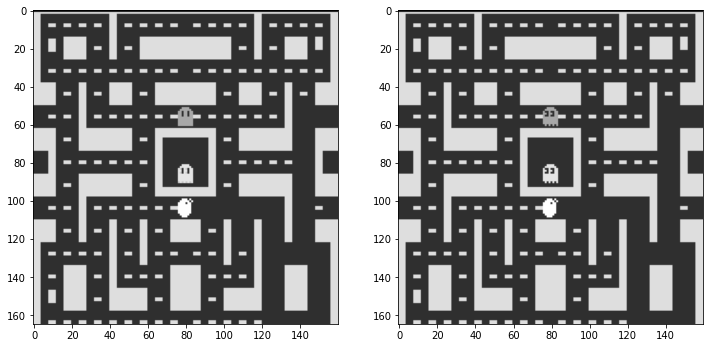

In [179]:
plot_state(s)

In [161]:
T.nn.functional.softmax(resnet(s), -1)

tensor([[0.0656, 0.1659, 0.0956, 0.0805, 0.0781, 0.0637, 0.2724, 0.0523, 0.1260]],
       grad_fn=<SoftmaxBackward>)

In [164]:
resnet = models.resnet50()
resnet.conv1 = T.nn.Conv2d(FRAMES_TO_STACK, 64, (7, 7), (2, 2), (3, 3), bias=False)
resnet.fc = T.nn.Linear(2048, NUM_ACTIONS)